### References
##### Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations 

https://www.sciencedirect.com/science/article/pii/S0021999118307125

##### Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations

https://arxiv.org/pdf/1711.10561.pdf

##### Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations

https://arxiv.org/pdf/1711.10566.pdf

##### Authors: Maziar Raissi, Paris Perdikaris, George Em Karniadakis

https://github.com/maziarraissi/PINNs <br>
https://maziarraissi.github.io/PINNs/

### 1)Burgers' equation
Physics form:
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} = \nu \frac{\partial^2 u(t,x)}{\partial x^2}$$
$u(t,x)$: velocity of fluid, $\nu$: viscosity of fluid <br><br>

General form:
$$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$<br>

In Maziar Raissi, Paris Perdikaris, and George Em Karniadakis paper: <br>
$$\frac{\partial u(t,x)}{\partial t} + u(t,x) \frac{\partial u(t,x)}{\partial x} -\frac{0.01}{\pi} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$ <br>
$$u(0,x) = -sin(\pi x) \textrm{, which is the initial condition}$$ <br>
$$u(t,-1) = u(t,1) = 0 \textrm{, which is the Dirichlet boundary conditions}$$<br>
$$x \in [-1,1], \textrm{ }t\in [0,1]$$
Close to the exact solution is $u(t,x) = e^{-t}sin(\pi x)$, [here is the exact analytical solution.](https://www.sciencedirect.com/science/article/abs/pii/0045793086900368)

### 2)PINN approach: Inference => find u(t,x) (Appendix A1 Data-driven solution of partial differential equations)
In this part, we are looking to find the exact solution of the PDE (partial derivate equation), $u(t,x)$. The PDE, boundary and inital conditions are known, $u(t,x)$ is unknown.

Define $f := u_t + uu_x - \frac{0.01}{\pi}u_{xx}$, this function is an approximation of the Burgers' equation / the true PDE given by the PINN. <br>

```python
def f(t,x):
    u=u(t,x)
    u_t=tf.gradients(u,t)[0]
    u_x=tf.gradients(u,x)[0]
    u_xx=tf.gradients(u_x,x)[0]
    f=u_t+u∗u_x−(0.01/tf.pi)∗u_xx
return f
```

```u(t,x)``` is the approximation given by the PINN of the solution that satisfies the true PDE. ```u(t,x)``` PINN approximation of $u(t,x)$ the exact solution.

```python
def u(t,x):
    u=neural_net(tf.concat([t,x],1),weights,biases)
return u
```

In other words: ```u(t,x)= PINN(t,x) == PINN u``` and ```f(t,x) == PINN PDE``` <br><br>

The loss is defined by: $MSE = MSE_f + MSE_u$, it is a combination of the PDE loss $MSE_f$ and the boundary & initial conditions loss $MSE_u$. <br>
$MSE_f = \frac{1}{N_f}\Sigma_{i=1}^{N_f} |f(t_f^i,x_f^i)|^2$, where $\{t_f^i,x_f^i\}_{i=1}^{N_f}$ is the grid generated for the PDE. <br>
$MSE_u = \frac{1}{N_u}\Sigma_{i=1}^{N_u} |u(t_u^i,x_u^i) - u^i|^2$, where $\{t_u^i,x_u^i\}_{i=1}^{N_u}$ is the grid generated for the boundary & initial conditions, ```u^i``` is an exact solution point from the boundary and initial conditions, ```u(t_u^i,x_u^i)``` is an approximation of $u(t,x)$ (the exact solution) given by the PINN.<br><br>

Architecture used:
- 9 layers
- 20 neurons
- LBFGS optimizer
- Weights xavier init
- Activation function: tanh
- Nu = 100: bc and ic points
- Nf = 10000: PDE / collocation points

Remark: we want to solve the true PDE without knowing its solution, it can be seen as an unsupervised task where the data required is only the boundary and initial conditions (t = 0, x = -1, 1)).

**The collocation points are not shown as they are user generated**

<div>
<img src="img/1.PNG" width="500"/>
</div>
<div>
<img src="img/2.PNG" width="500"/>
</div>

### 3)PINN Approach: Identification => find the PDE (Appendix B1 Data-driven discovery of partial differential equations)

In this part, the solution $u(x,t)$ is known and we want to discover the parameters of the equation $F(t, x, u(t, x), \lambda) = 0.$ This is a supervised task, the dataset is constituted of $N$ points, which are randomly selected in the entire space-time domain  $\Omega = [0, 1] \times [-1, 1]$, $S = \{t_i, x_i, u(t_i, x_i)\}_{i=1}^N$, this dataset gives the solution for every $(t, x) \in \Omega$. The information from the boundary & intial conditions is encoded in the dataset, $x \in [-1,1]$, $t \in [0,1]$ and $u(t,x)$ in the interior of $\Omega$. <br>

$u(t,x)$ the exact solution is known, the true PDE is unknown, the boundary and inital conditions are known and are only used for the generation of points in $\Omega$. <br>

The general Burgers' equation in 1D is: $$\frac{\partial u(t,x)}{\partial t} + \lambda _{1} u(t,x) \frac{\partial u(t,x)}{\partial x} -\lambda _{2} \frac{\partial^2 u(t,x)}{\partial x^2} = 0$$ 

Define $f := u_t + \lambda _1 u u_x - \lambda _2 u_{xx}$, (link with $F$: $\lambda = (\lambda_1,\lambda_2)$), this will be an approximation of the PDE given by the PINN, ```u(t,x)``` approximation of the exact solution given by the PINN.

The loss is defined by: $MSE = MSE_f + MSE_u$, it is a combination of the PDE loss $MSE_f$ and the training data loss $MSE_u$. <br>
$MSE_f = \frac{1}{N}\Sigma_{i=1}^{N} |f(t_u^i,x_u^i)|^2$ <br>
$MSE_u = \frac{1}{N}\Sigma_{i=1}^{N} |u(t_u^i,x_u^i) - u^i|^2$ <br>

Where $\{t_u^i,x_u^i,u^i\}_{i=1}^{N}$ is the training dataset. ***Note*: here we use the same training set on both losses.**

Architecture used:
- 9 layers
- 20 neurons
- LBFGS optimizer
- Weights xavier init
- Activation function: tanh
- N = 2000 

Expected $\lambda$: $\lambda_1 = 1.0$ and $\lambda_2 = \frac{0.01}{\pi} \approx 0.00318$

<div>
<img src="img/3.PNG" width="500"/>
</div>
<div>
<img src="img/4.PNG" width="500"/>
</div>

### 4)Implementation of Burgers' equation Inference in Pytorch 

intial condition: $u(0,x) = -sin(\pi x)$ <br>
boundary condition 1: $u(t,-1) = 0$ <br>
boundary condition 2: $u(t,1) = 0$ <br>
$x \in [-1,1]$ and $t \in [0,1]$ <br>
$N_u = 100$ randomly initial and boundary condtions, which are considered as the training data. <br>
$N_f = 10000$ random collocations points, collocations points are points in the domain to test that the solution satisfies the PDE at the collocation points. The collocation points are generated using **latin hypercube sampling** to equally distribute the points in the domain.<br>
*Note*: for the collocations points we can add the initial and boundary conditions points. <u>Burgers_shock.mat</u> has $100$ points for $t \in [0,0.99]$, $256$ points for $x \in [-1,1]$ and the exact $u(t,x)$ at these points ($25600$ pairs of $(t,x)$). <br><br>
Training process:
- Create the network, input is a pair $(t,x)$, size 2.
- 9 hidden layers with 20 nodes, and tanh as activation function
- the output is $u(t,x)$ a real number, size 1.
- feedforward the ic/bc and collocations through the PINN
- calculate the combined MSE loss = MSEu + MSEf
- max_iters is defined in the lbfgs optimizer

In [10]:
import torch
from torch import nn 
torch.manual_seed(0)
#from torch.nn import functional as F #no need if use torch.tanh

class Net(nn.Module):
    #def __init__(self, n_layers, n_neurons): #add number of layers and neurones as parameters
    def __init__(self):
        super(Net, self).__init__() 

        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 20)
        self.fc5 = nn.Linear(20, 20)
        self.fc6 = nn.Linear(20, 20)
        self.fc7 = nn.Linear(20, 20)
        self.fc8 = nn.Linear(20, 20)
        self.fc9 = nn.Linear(20, 1)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = torch.tanh(self.fc5(x))
        x = torch.tanh(self.fc6(x))
        x = torch.tanh(self.fc7(x))
        x = torch.tanh(self.fc8(x))
        x = torch.tanh(self.fc9(x))
        return x


net = Net()
print(net)

params = list(net.parameters())
#print(len(params))
for par in params:
    print(par.shape)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (fc6): Linear(in_features=20, out_features=20, bias=True)
  (fc7): Linear(in_features=20, out_features=20, bias=True)
  (fc8): Linear(in_features=20, out_features=20, bias=True)
  (fc9): Linear(in_features=20, out_features=1, bias=True)
)
torch.Size([20, 2])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([20, 20])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [11]:
import torch.optim as optim
import numpy as np

class PINN():
    def __init__(self, X_u, u, X_f, lb, ub, nu): #X_u_train, u_train, X_f_train, lb, ub, nu
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print(f"device used: {self.device}")
       
    
        self.lb = torch.tensor(lb).float().to(self.device) #2, [-1,0] xmin, tmin
        self.ub = torch.tensor(ub).float().to(self.device) #2 [1,0] xmamx, tmax
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(self.device) #100,1; 100 random ic/bc pairs, take the x
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(self.device) #100,1; 100 random ic/bc pairs, take the t
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(self.device) #10456, 1; 10456 pairs for collocation, take the x
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(self.device) #10456, 1; 10456 pairs for collocation, take the t
        self.u = torch.tensor(u).float().to(self.device) #100, 1; exact solution for the 100 random ic/bc pairs
        self.nu = nu #float 0.01/pi
        
        self.net = Net().to(self.device)
        #self.criterion = nn.MSELoss()
        #self.optimizer = optim.Adam(self.net.parameters(), lr=0.001)
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, #1e-8
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )

        self.iter = 0
        
    def net_u(self, x, t): #get u(x,t) for a pair (x,t); a forward pass through the PINN
        u = self.net(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t): #get f = u_t + u * u_x - self.nu * u_xx; the true u(x,t) makes f = 0
        u = self.net_u(x, t)
        u_t = torch.autograd.grad( #first partial derivative with respect to t
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( #first partial derivative with respect to x
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( #second partial derivative with respect to x
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t + u * u_x - self.nu * u_xx #the computed PDE, we want to be a close as possible to 0
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u) #100, 1; all the ic/bc pairs were feeded through the PINN
        f_pred = self.net_f(self.x_f, self.t_f) #10456, 1; all the collocations points were feeded through the PINN
        loss_u = torch.mean((self.u - u_pred) ** 2) #MSE loss on the ic/bc pairs, MSE loss on trainset, classic NN
        loss_f = torch.mean(f_pred ** 2) #MSE loss on the collocations pairs, regularization term
        
        loss = loss_u + loss_f #classic loss + regularization loss (enforce the PDE structure) => PINN loss
        
        loss.backward() #backpropagation
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self):
        self.net.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(self.device) #get x from pair
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(self.device) #get t from pair

        self.net.eval()
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [12]:
import scipy.io
from pyDOE import lhs

nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None] #100,1
x = data['x'].flatten()[:,None] #256,1
Exact = np.real(data['usol']).T #256,100

X, T = np.meshgrid(x,t) #X 100,256; T 100,256

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #25600, 2, exact solution input pairs (t,x)
u_star = Exact.flatten()[:,None] #25600, 1, exact solution u(t,x)             

# Domain bounds
lb = X_star.min(0) #(-1, 0) (xmin, tmin); min(0) for min per column
ub = X_star.max(0) #(1, 0.99) (xmax, tmax)

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #256, 2; corresponds to the initial condition points u(t=0,x) = -sin(pix)
# X[0:1,:].T vector of all the values of x from -1 to 1 of shape (256,1)
# T[0:1,:].T vector of 0s of shape (256,1)
uu1 = Exact[0:1,:].T #256, 1, exact solution for the initial condition

xx2 = np.hstack((X[:,0:1], T[:,0:1])) #100, 2; correspond to the first boundary condition u(t,x=-1) = 0
# X[:,0:1] : vector of -1s of shape (100,1)
# T[:,0:1] : vector of t values from 0 to 0.99 of shape (100,1)
uu2 = Exact[:,0:1] #100, 1; exact solution for the first boundary condition

xx3 = np.hstack((X[:,-1:], T[:,-1:])) #100, 2; corresponds to the second boundary condition u(t,x=1) = 0
# X[:,-1:] : vector of 1s of shape (100,1)
# T[:,-1:] : vector of t values from 0 to 0.99 of shape (100,1)
uu3 = Exact[:,-1:] #100, 1; exact solution for the second boundary condition

X_u_train = np.vstack([xx1, xx2, xx3]) #456, 2 #points of initial and boundaries conditions points
X_f_train = lb + (ub-lb)*lhs(2, N_f) #10000, 2 #Latin hypercube sampling: creates 10000 near random pairs of (x,t) in 
# the domain [-1,1]x[0,0.99], used for PDE
X_f_train = np.vstack((X_f_train, X_u_train)) #10456, 2 #stack initial and boundaries points with PDE points, so all the
# the initial and boundaries points can also be used for the PDE 
u_train = np.vstack([uu1, uu2, uu3]) # 456, 1; stack the exact solution points for initial and boundaries conditions

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False) #(100,) 100 permutations from the 456 initial 
# and boundaries conditions, N_u = 100
X_u_train = X_u_train[idx, :] #100,2 randomly points from the 456 initial and boundaries conditions
u_train = u_train[idx,:] #100,1 randomly points from the 456 exact solutions points of initial and boundaries conditions

In [13]:
#X_u_train 100,2 randomly points from the 456 initial and boundaries conditions, why not used 456,2
#u_train 100,1 randomly points from the 456 exact solutions points of initial and boundaries conditions, why not 456,1
#X_f_train 10456, 2 #10000 PDE points + 456 initial and boundary conditions points all used for PDE training
#lb (-1,0) xmin and tmin
#ub (1,0.99) xmax and tmax
#nu a float representing 0.01/pi
model = PINN(X_u_train, u_train, X_f_train, lb, ub, nu)

model.train()

device used: cuda:0
Iter 100, Loss: 9.25561e-02, Loss_u: 6.36624e-02, Loss_f: 2.88937e-02
Iter 200, Loss: 4.38216e-02, Loss_u: 3.01116e-02, Loss_f: 1.37100e-02
Iter 300, Loss: 3.00619e-02, Loss_u: 1.79544e-02, Loss_f: 1.21075e-02
Iter 400, Loss: 2.13040e-02, Loss_u: 1.23426e-02, Loss_f: 8.96141e-03
Iter 500, Loss: 1.43401e-02, Loss_u: 8.21704e-03, Loss_f: 6.12310e-03
Iter 600, Loss: 9.24083e-03, Loss_u: 5.60248e-03, Loss_f: 3.63834e-03
Iter 700, Loss: 5.92966e-03, Loss_u: 3.15519e-03, Loss_f: 2.77447e-03
Iter 800, Loss: 4.04079e-03, Loss_u: 2.11245e-03, Loss_f: 1.92834e-03
Iter 900, Loss: 2.57684e-03, Loss_u: 1.02384e-03, Loss_f: 1.55299e-03
Iter 1000, Loss: 1.47834e-03, Loss_u: 5.51461e-04, Loss_f: 9.26880e-04
Iter 1100, Loss: 8.81684e-04, Loss_u: 3.53554e-04, Loss_f: 5.28130e-04
Iter 1200, Loss: 4.62278e-04, Loss_u: 1.50091e-04, Loss_f: 3.12187e-04
Iter 1300, Loss: 3.43906e-04, Loss_u: 1.14060e-04, Loss_f: 2.29846e-04
Iter 1400, Loss: 2.69815e-04, Loss_u: 9.11085e-05, Loss_f: 1.78706

In [18]:
def MSE (pred, true):
    return float(((pred - true)**2).mean(axis=0))

In [19]:
MSE(u_pred, u_star)

2.329429418158968e-06

In [20]:
MSE(f_pred, np.zeros(f_pred.shape))

1.126020636314062e-05

In [15]:
from scipy.interpolate import griddata

u_pred, f_pred = model.predict(X_star) #X_star is 25600, 2 contains the pairs who have a exact sol in burgers_shock.mat

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)  #u_star 25600,1 contains the exact solution
print('Error u: %e' % (error_u)) #use this metric to compare model performance      



U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred) #100, 256 matrix of errors compared to burgers_shock.mat

Error u: 2.484378e-03


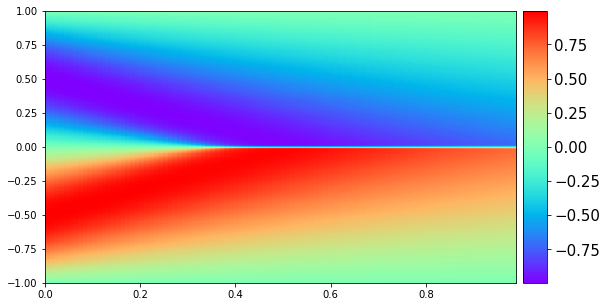

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

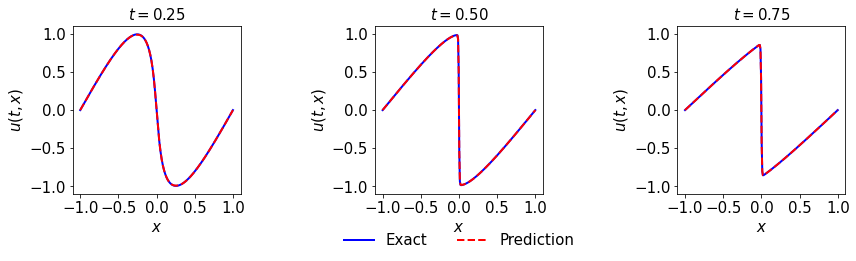

In [17]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### 5)Implementation of Burgers' equation Identification in Pytorch

In [1]:
import torch
from torch import nn 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')



In [2]:
from collections import OrderedDict

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out


In [10]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X, u, layers, lb, ub):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        self.t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        # settings
        self.lambda_1 = torch.tensor([0.0], requires_grad=True).to(device) #random guess
        self.lambda_2 = torch.tensor([-6.0], requires_grad=True).to(device) #random guess
        
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        self.dnn.register_parameter('lambda_1', self.lambda_1)
        self.dnn.register_parameter('lambda_2', self.lambda_2)
        
         # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):

        lambda_1 = self.lambda_1        
        lambda_2 = torch.exp(self.lambda_2)
       
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f
    
    def loss_func(self):
        u_pred = self.net_u(self.x, self.t)
        f_pred = self.net_f(self.x, self.t)
        
        loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
        #print("lbfgs zero grad")
        self.optimizer.zero_grad()
        #print("loss backward")
        loss.backward()
        
        self.iter += 1
        if self.iter % 100 == 0:
        #if True:
            print(
                'Loss: %e, l1: %.5f, l2: %.5f' % 
                (
                    loss.item(), 
                    self.lambda_1.item(), 
                    torch.exp(self.lambda_2.detach()).item()
                )
            )
        return loss
    
    def train(self, nIter):
        #print("Before Training")
        self.dnn.train()
        #print("After Training")
        for epoch in range(nIter):
            #print("Inside nIter")
            u_pred = self.net_u(self.x, self.t)
            f_pred = self.net_f(self.x, self.t)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            
            # Backward and optimize
            #print("adam zero grad")
            self.optimizer_Adam.zero_grad()
            #print("loss backward")
            loss.backward()
            #print("adam step")
            self.optimizer_Adam.step()
            
            if epoch % 100 == 0:
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f' % 
                    (
                        epoch, 
                        loss.item(), 
                        self.lambda_1.item(), 
                        torch.exp(self.lambda_2).item()
                    )
                )
        #print("ADAM FINISHED")
                
        # Backward and optimize
        #print("lbfgs step")
        self.optimizer.step(self.loss_func)
    
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f


In [11]:
import scipy.io
import numpy as np
nu = 0.01/np.pi

N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0) 

In [12]:
%%time

noise = 0.0            

# create training set
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx,:]
u_train = u_star[idx,:]

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(0)


Loss: 2.363190e-02, l1: 0.21112, l2: 0.00230
Loss: 1.609356e-02, l1: 0.35779, l2: 0.00265
Loss: 1.122631e-02, l1: 0.50490, l2: 0.00370
Loss: 6.432255e-03, l1: 0.71798, l2: 0.00516
Loss: 3.512854e-03, l1: 0.83796, l2: 0.00596
Loss: 2.418379e-03, l1: 0.91890, l2: 0.00649
Loss: 1.985400e-03, l1: 0.91610, l2: 0.00614
Loss: 1.569006e-03, l1: 0.94420, l2: 0.00601
Loss: 1.235722e-03, l1: 0.95812, l2: 0.00580
Loss: 1.012350e-03, l1: 0.96839, l2: 0.00548
Loss: 8.138429e-04, l1: 0.96921, l2: 0.00507
Loss: 6.674743e-04, l1: 0.96798, l2: 0.00484
Loss: 5.798078e-04, l1: 0.97251, l2: 0.00459
Loss: 5.007347e-04, l1: 0.97231, l2: 0.00441
Loss: 4.345248e-04, l1: 0.97298, l2: 0.00425
Loss: 3.950587e-04, l1: 0.97900, l2: 0.00420
Loss: 3.552871e-04, l1: 0.97794, l2: 0.00412
Loss: 3.267297e-04, l1: 0.97748, l2: 0.00408
Loss: 2.909168e-04, l1: 0.98714, l2: 0.00401
Loss: 2.541124e-04, l1: 0.98086, l2: 0.00400
Loss: 2.254489e-04, l1: 0.98033, l2: 0.00397
Loss: 1.974022e-04, l1: 0.98930, l2: 0.00385
Loss: 1.74

In [13]:
from scipy.interpolate import griddata
# evaluations
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.lambda_1.detach().cpu().numpy()
lambda_2_value = model.lambda_2.detach().cpu().numpy()
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1))                             
print('Error l2: %.5f%%' % (error_lambda_2))  


Error u: 9.526112e-03
Error l1: 0.74378%
Error l2: 4.54436%


In [14]:
noise = 0.01    

# create training set
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])

# training
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.train(2000)            


It: 0, Loss: 3.807e-01, Lambda_1: -0.001, Lambda_2: 0.002480
It: 100, Loss: 9.508e-02, Lambda_1: -0.013, Lambda_2: 0.002440
It: 200, Loss: 3.182e-02, Lambda_1: 0.071, Lambda_2: 0.002212
It: 300, Loss: 2.708e-02, Lambda_1: 0.096, Lambda_2: 0.002240
It: 400, Loss: 2.381e-02, Lambda_1: 0.146, Lambda_2: 0.002258
It: 500, Loss: 2.134e-02, Lambda_1: 0.202, Lambda_2: 0.002295
It: 600, Loss: 1.826e-02, Lambda_1: 0.265, Lambda_2: 0.002334
It: 700, Loss: 1.561e-02, Lambda_1: 0.337, Lambda_2: 0.002423
It: 800, Loss: 1.352e-02, Lambda_1: 0.393, Lambda_2: 0.002579
It: 900, Loss: 1.133e-02, Lambda_1: 0.442, Lambda_2: 0.002779
It: 1000, Loss: 9.538e-03, Lambda_1: 0.492, Lambda_2: 0.002938
It: 1100, Loss: 8.687e-03, Lambda_1: 0.537, Lambda_2: 0.003016
It: 1200, Loss: 6.902e-03, Lambda_1: 0.578, Lambda_2: 0.003083
It: 1300, Loss: 6.172e-03, Lambda_1: 0.608, Lambda_2: 0.003133
It: 1400, Loss: 6.466e-03, Lambda_1: 0.639, Lambda_2: 0.003167
It: 1500, Loss: 5.225e-03, Lambda_1: 0.662, Lambda_2: 0.003204
It

NameError: name 'make_axes_locatable' is not defined

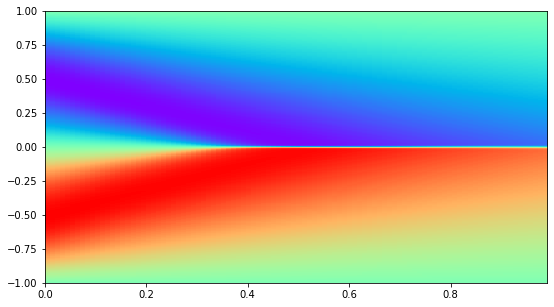

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=.5
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

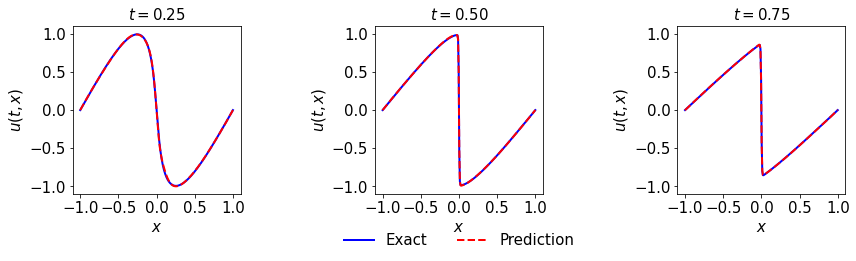

In [18]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

In [19]:

# evaluations
u_pred, f_pred = model.predict(X_star)

lambda_1_value_noisy = model.lambda_1.detach().cpu().numpy()
lambda_2_value_noisy = model.lambda_2.detach().cpu().numpy()
lambda_2_value_noisy = np.exp(lambda_2_value_noisy)

error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0) * 100
error_lambda_2_noisy = np.abs(lambda_2_value_noisy - nu) / nu * 100

print('Error u: %e' % (error_u))    
print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
print('Error l2: %.5f%%' % (error_lambda_2_noisy))    

Error u: 9.526112e-03
Error l1: 0.12287%
Error l2: 0.59990%


In [20]:
####### Row 3: Identified PDE ##################    

print(f"Correct PDE                 lambda1 = 1,                  lambda2 = {0.01/np.pi}")
print(f"Identified PDE (clean data) lambda1 = {lambda_1_value[0]}, lambda2 = {lambda_2_value[0]}")
print(f"Identified PDE (noise 1%)   lambda1 = {lambda_1_value_noisy[0]}, lambda2 = {lambda_2_value_noisy[0]}")

Correct PDE                 lambda1 = 1,                  lambda2 = 0.003183098861837907
Identified PDE (clean data) lambda1 = 0.9925622344017029, lambda2 = 0.003327750600874424
Identified PDE (noise 1%)   lambda1 = 0.9987713098526001, lambda2 = 0.0031640036031603813
